<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2023/blob/main/Python/CP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Difference for 1D reaction-advection-diffusion problem

1. Finite Difference solver for the reaction-advection-diffusion problem:

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 1D FD algebric system

In [2]:
def FD1D(omega,N,alpha,beta,gamma,rhs):
  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format
  # over domain omega

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)

  # compute rhs
  f = rhs(x[1:-1])
  
  # evaluate PDE coeffs
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)

  # compute diagonal entries
  diff_term = [-diff[1:N+1],2*diff,-diff[0:-1]]
  conv_term = [-conv[1:N+1],conv[0:-1]]
  reac_term = reac

  # compute systmen matrix
  A = 1/(h*h) * sp.diags(diff_term,[-1,0,1],format="csr") + 1/(2*h) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac_term,format="csr")

  # apply boundary conditions

  return A[1:-1,1:-1],f

Define FD problem and solve

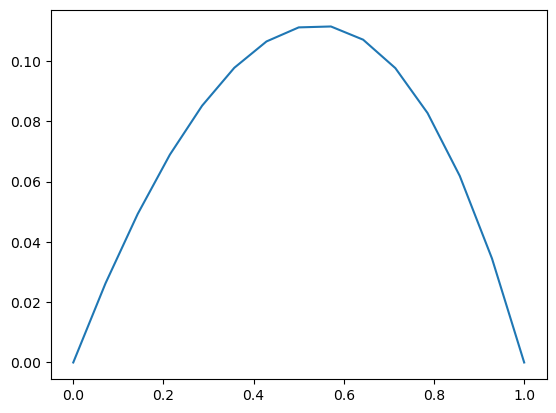

In [25]:
# Problem domain
omega = [0,1]

alpha = lambda x : (1.) * np.ones(len(x))
beta = lambda x :  1 * np.ones(len(x))
gamma = lambda x : 1 * np.ones(len(x))
rhs = lambda x :   1. * np.ones(len(x))

# Grid parameters
N=14
h = (omega[1]-omega[0])/N

# FD system
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)


# solve
Uh = spsolve(A,F) 

# insert boundary conditions
Uh = np.insert(Uh,[0,N-1],(0,0))

# plot solution
x = np.linspace(omega[0],omega[1],N+1)
plt.plot(x,Uh)

Repeat exercise with larger system including boundary conditions

In [26]:
def FD1Do(omega,N,alpha,beta,gamma,rhs):
  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)

  # compute coeffs
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)
  F = rhs(x)

  diff_term = [-diff[1:N+1],2*diff,-diff[0:-1]]
  conv_term = [-conv[1:N+1],conv[0:-1]]
  reac_term = reac
  
  A = 1/(h*h) * sp.diags(diff_term,[-1,0,1],format="csr") + 1/(2*h) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac_term,format="csr")

  # modify system to account for homogeneous Dirichlet boundary conditions
  A[0,0] = 1; A[0,1] = 0; F[0] = 0
  A[-1,-1] = 1; A[-1,-2] = 0; F[-1] = 0
  return A, F

Solve again with new routine

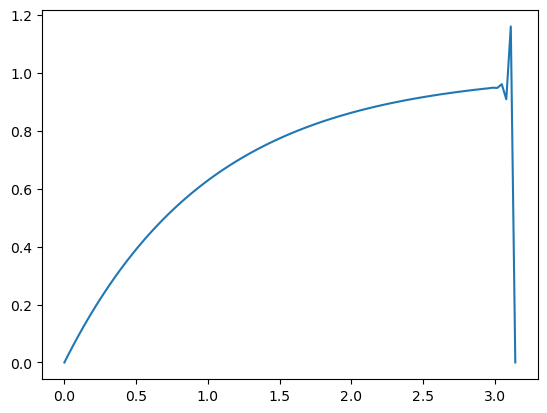

In [32]:
# Problem domain
omega = [0,np.pi]

alpha = lambda x : .01 * np.ones(len(x))
beta = lambda x :  1. * np.ones(len(x))
gamma = lambda x : 1. * np.ones(len(x))
rhs = lambda x :   1. * np.ones(len(x))

# Grid parameters
N=100
h = (omega[1]-omega[0])/N

# FD system
A, F = FD1Do(omega,N,alpha,beta,gamma,rhs)

# solve
U = spsolve(A,F)

# plot solution
x = np.linspace(omega[0],omega[1],N+1)
plt.plot(x,U)

Compute experimental order of convergence (EOC) using knowledge that 

$|| U-U_h ||_\infty \approx C h^k$

with $C$ independent of $h$. Hence,

$\frac{|| U-U_{h_1} ||_\infty}{|| U-U_{h_2} ||_\infty}\approx\large(\frac{h_1}{h_1}\large)^k$,

and then,

$k\approx\frac{\log || U-U_{h_1} ||_\infty-\log|| U-U_{h_2} ||_\infty}{\log h_1 - \log h_2}$.

Notice that to estimate the EOC you need to run at least two experiments, for instance with $h_1=h$, $h_2=h/2$.

In [3]:
# Problem domain
omega = [0,np.pi]

alpha = lambda x : 1. * np.ones(len(x))
beta = lambda x :  0. * np.ones(len(x))
gamma = lambda x : 0. * np.ones(len(x))
rhs =   lambda x : np.sin(x)
sol =   lambda x : np.sin(x)

# Fix number of experiments
no_experiments = 12

# initialise with first experiment
N = 5
h = (omega[1]-omega[0])/N
x = np.linspace(omega[0],omega[1],N+1)

# evaluate system for given N
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)
# Solve
U1 = sp.linalg.spsolve(A,F)
# compute error
err1 = np.linalg.norm(sol(x[1:-1])-U1,ord=np.inf)

for i in range(no_experiments-1):
  # fix the mesh
  N= 2 * N
  h2 = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)
  # evaluate system for given N
  A, F = FD1D(omega,N,alpha,beta,gamma,rhs)
  # Solve
  U = sp.linalg.spsolve(A,F)
  # Compute error 
  err2 = np.linalg.norm(sol(x[1:-1])-U,ord=np.inf)
  k = (np.log(err1)-np.log(err2))/(np.log(h)-np.log(h2))
  # Update
  h = h2
  err1 = err2
  print(k)




1.9491170242966338
2.005349249284457
2.001335495008629
2.0003337603239038
2.0000834328344603
2.0000208643954394
2.000005321316897
2.000000275676347
1.9999793276108875
1.999888502471435
2.0008925689287156


What if the exact solution is not known? Then we can still estiate the EOC but three experiments. Indeed, letting $h_2=\theta h_1$, we have

$|| U_{h_2}-U_{h_1} ||_\infty\le || U-U_{h_1} ||_\infty + || U-U_{h_2} ||_\infty\approx C h_1^k+C h_2^k \approx C (1+\theta^k) h_1^k$

Now, given also $h_3 = \theta h_2$, we have similarly

$|| U_{h_3}-U_{h_2} ||_\infty \approx C (1+\theta^k) h_2^k=C (1+\theta^k)\theta^k h_1^k$

hence,

$\frac{|| U_{h_2}-U_{h_1} ||_\infty}{|| U_{h_3}-U_{h_2} ||_\infty}\approx \frac{C (1+\theta^k) h_1^k}{C (1+\theta^k)\theta^k h_1^k}=\theta^{-k}$

from which $k$ can be estimated as before by passing to the logs.

NOTE! The discrete solutions are defined at different sets of points so the above comparison is to be intended on the set of common points!

**Exercise:** try this out for the problem with $f=1$.